In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load  data
df = pd.read_csv('uae_real_estate_2024.csv')
print(f"the data: {df.shape[0]} ")
df.head()

the data: 5058 


,title,displayAddress,bathrooms,bedrooms,addedOn,type,price,verified,priceDuration,sizeMin,furnishing,description
0,Great ROI I High Floor I Creek View,"Binghatti Canal, Business Bay, Dubai",3,2,2024-08-14T12:02:53Z,Residential for Sale,2500000,True,sell,1323 sqft,NO,MNA Properties is delighted to offer this apar...
1,Full Sea View | Beach Life | Brand New Residence,"La Vie, Jumeirah Beach Residence, Dubai",3,2,2024-08-13T05:45:16Z,Residential for Sale,7200000,True,sell,1410 sqft,YES,"Apartment for sale in La Vie, Jumeirah Beach R..."
2,Green Belt | Corner Unit | Spacious Plot,"La Rosa 6, Villanova, Dubai Land, Dubai",3,4,2024-08-14T06:24:28Z,Residential for Sale,3600000,True,sell,2324 sqft,NO,Treo Homes is very pleased to be bringing to t...
3,2BR+Study | Near Pool and Park | Private,"Springs 15, The Springs, Dubai",3,2,2024-08-15T06:07:22Z,Residential for Sale,2999999,True,sell,1647 sqft,NO,2 Bedrooms + Study | Near Pool &amp; Park | Pr...
4,Vacant | Well Maintained | Area Expert,"Noor Townhouses, Town Square, Dubai",3,3,2024-08-09T08:28:59Z,Residential for Sale,2449999,True,sell,2105 sqft,NO,-Type 1\n-3 Bed+Maid\n-Close To Amenities\n-BU...


In [3]:
print(df.dtypes)  # data type

title             object
displayAddress    object
bathrooms         object
bedrooms          object
addedOn           object
type              object
price              int64
verified            bool
priceDuration     object
sizeMin           object
furnishing        object
description       object
dtype: object


In [4]:
print(df.isnull().sum())    #missing value

title               0
displayAddress      0
bathrooms         120
bedrooms          123
addedOn             0
type                0
price               0
verified            0
priceDuration       0
sizeMin             0
furnishing          2
description         1
dtype: int64


In [5]:
#  replace  numerical columns with median
df['bathrooms'] = pd.to_numeric(df['bathrooms'], errors='coerce')
df['bedrooms'] = pd.to_numeric(df['bedrooms'], errors='coerce')


df['bathrooms'] = df['bathrooms'].fillna(df['bathrooms'].median())
df['bedrooms'] = df['bedrooms'].fillna(df['bedrooms'].median())


# categorical replace with mode
df['furnishing'] = df['furnishing'].fillna(df['furnishing'].mode()[0])
df['description'] = df['description'].fillna('No description ')

print("confirm the missing after ")
print(df.isnull().sum())

confirm the missing after 
title             0
displayAddress    0
bathrooms         0
bedrooms          0
addedOn           0
type              0
price             0
verified          0
priceDuration     0
sizeMin           0
furnishing        0
description       0
dtype: int64


In [6]:
# data type conversion 
# the date in dataset is 2024-08-15T06:07:22Z
# Convert date handle timezone 
df['addedOn'] = pd.to_datetime(df['addedOn'], errors='coerce')


if df['addedOn'].dt.tz is not None:
    # Convert to time zone by remove timezone 
    df['addedOn'] = df['addedOn'].dt.tz_convert(None)
    
# Calculate days on market 
current_date = pd.Timestamp.now().normalize()  # normalize to remove time 
df['days_on_market'] = (current_date - df['addedOn'].dt.normalize()).dt.days
df['days_on_market'] = df['days_on_market'].fillna(df['days_on_market'].median())


# seperate area from address
def extract_area(address):
    if isinstance(address, str):
        # get first part of address 
        areas = address.split(',')
        return areas[0].strip() if areas else 'Unknown'
    return 'Unknown'
df['area'] = df['displayAddress'].apply(extract_area)

In [8]:
# Clean property type
df['type'] = df['type'].str.strip().str.title()

#  price categories for classification
def categorize_price(price):
    if price <= 1000000:
        return 'low-economy'
    elif price <= 5000000:
        return 'Medium'
    else:
        return 'Luxury'

df['price_category'] = df['price'].apply(categorize_price)


In [9]:
# extract the number sizeMin 
import re
def clean_size(size):
    if isinstance(size, (int, float)):
        return size
    elif isinstance(size, str):
        numbers = re.findall(r'\d+\.?\d*', str(size))
        return float(numbers[0]) if numbers else np.nan
    else:
        return np.nan

df['size_clean'] = df['sizeMin'].apply(clean_size)
df['size_clean'] = df['size_clean'].fillna(df['size_clean'].median())

# Verify after seprate
print( df['size_clean'].head())

0    1323.0
1    1410.0
2    2324.0
3    1647.0
4    2105.0
Name: size_clean, dtype: float64


In [10]:
# Find outliers in price column
Q1_price = df['price'].quantile(0.25)  # less than 25% 
Q3_price = df['price'].quantile(0.75)   #   less than 75% 
IQR_price = Q3_price - Q1_price    # spring range

lower_price = Q1_price - 1.5 * IQR_price    #  minimum  normal
upper_price = Q3_price + 1.5 * IQR_price     #  maximum normal

# Find outliers
price_outliers = df[(df['price'] < lower_price) | (df['price'] > upper_price)]
print(f"the price outliers {len(price_outliers)} ")

#  for size
Q1_size = df['size_clean'].quantile(0.25)
Q3_size = df['size_clean'].quantile(0.75)
IQR_size = Q3_size - Q1_size

lower_size = Q1_size - 1.5 * IQR_size
upper_size = Q3_size + 1.5 * IQR_size

size_outliers = df[(df['size_clean'] < lower_size) | (df['size_clean'] > upper_size)]
print(f"the size outlier {len(size_outliers)} ")

# clear outlier using capping 
df['price_clean'] = df['price'].copy()
df.loc[df['price'] > upper_price, 'price_clean'] = upper_price
df.loc[df['price'] < lower_price, 'price_clean'] = lower_price

df['size_clean'] = df['size_clean'].copy()
df.loc[df['size_clean'] > upper_size, 'size_clean'] = upper_size
df.loc[df['size_clean'] < lower_size, 'size_clean'] = lower_size



the price outliers 539 
the size outlier 502 


In [11]:


#  rename columns for analysis
analytical_columns = {
    'price_clean': 'price',
    'bedrooms': 'bedrooms', 
    'bathrooms': 'bathrooms',
    'size_clean': 'size_sqft',
    'type': 'property_type',
    'area': 'location',
    'furnishing': 'furnishing',
    'price_category': 'price_category',
    'days_on_market': 'days_on_market',
    'verified': 'verified'
}

analysis_df = df[list(analytical_columns.keys())].copy()
analysis_df = analysis_df.rename(columns=analytical_columns)


In [12]:
# data quality 

print(" shape:", analysis_df.shape)

print(analysis_df.dtypes)

print(analysis_df.describe())

print(analysis_df.isnull().sum())

#  save this data
analysis_df.to_csv('uae_real_estate_cleaned.csv', index=False)
print("\n save as 'uae_real_estate_cleaned.csv'")


 shape: (5058, 10)
price             float64
bedrooms          float64
bathrooms         float64
size_sqft         float64
property_type      object
location           object
furnishing         object
price_category     object
days_on_market      int64
verified             bool
dtype: object
              price     bedrooms    bathrooms    size_sqft  days_on_market
count  5.058000e+03  5058.000000  5058.000000  5058.000000     5058.000000
mean   3.351336e+06     2.528470     3.013049  2082.518238      490.920720
std    2.833685e+06     1.361814     1.654515  1694.408015       52.898643
min    1.000000e+05     1.000000     1.000000    82.000000      447.000000
25%    1.200000e+06     1.250000     2.000000   802.000000      460.000000
50%    2.350000e+06     2.000000     3.000000  1419.000000      475.000000
75%    4.499375e+06     3.000000     4.000000  2799.750000      501.000000
max    9.448438e+06     7.000000     7.000000  5796.375000     1621.000000
price             0
bedrooms    

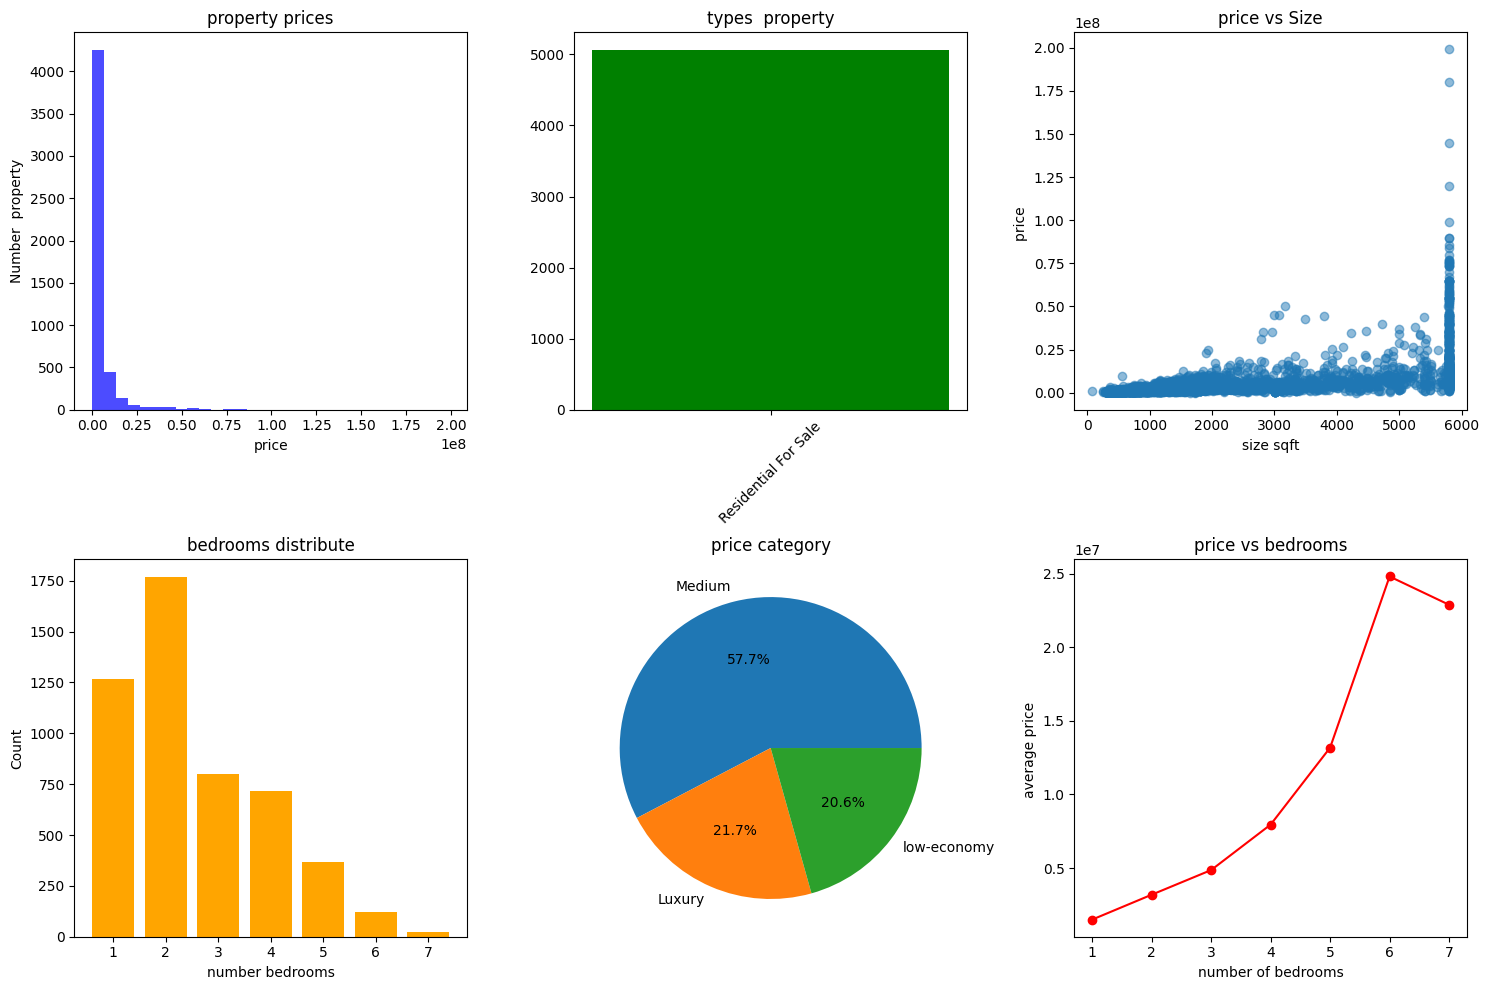


  Statistics 
Average bedrooms: 2.5
Average bathrooms: 3.0
Average size: 2083 
\ categoriesn Price:
- low-economy: 1044 property (20.6%)
- Medium: 2917 property (57.7%)
- Luxury: 1097 property (21.7%)

correlation between size and price: 0.572


In [13]:
plt.figure(figsize=(15, 10))

# Chart Price distribute
plt.subplot(2, 3, 1)
plt.hist(df['price'], bins=30, color='blue', alpha=0.7)
plt.title('property prices')
plt.xlabel('price')
plt.ylabel('Number  property')

#  chart property type
plt.subplot(2, 3, 2)
property_counts = df['type'].value_counts()
plt.bar(property_counts.index, property_counts.values, color='green')
plt.title('types  property')
plt.xticks(rotation=45)

# Chart  Price vs Size
plt.subplot(2, 3, 3)
plt.scatter(df['size_clean'], df['price'], alpha=0.5)
plt.xlabel('size sqft')
plt.ylabel('price ')
plt.title('price vs Size')

# Chart bedrooms distribution
plt.subplot(2, 3, 4)
bedroom_counts = df['bedrooms'].value_counts().sort_index()
plt.bar(bedroom_counts.index, bedroom_counts.values, color='orange')
plt.xlabel('number bedrooms')
plt.ylabel('Count')
plt.title('bedrooms distribute')

# Chart 5: Price categories
plt.subplot(2, 3, 5)
price_counts = df['price_category'].value_counts()
plt.pie(price_counts.values, labels=price_counts.index, autopct='%1.1f%%')
plt.title('price category')

# Chart 6: Average price by bedrooms
plt.subplot(2, 3, 6)
avg_price_by_bedrooms = df.groupby('bedrooms')['price'].mean()
plt.plot(avg_price_by_bedrooms.index, avg_price_by_bedrooms.values, marker='o', color='red')
plt.xlabel('number of bedrooms')
plt.ylabel('average price ')
plt.title('price vs bedrooms')

plt.tight_layout()
plt.show()

# statistics
print("\n  Statistics ")
print(f"Average bedrooms: {df['bedrooms'].mean():.1f}")
print(f"Average bathrooms: {df['bathrooms'].mean():.1f}")
print(f"Average size: {df['size_clean'].mean():.0f} ")

print(f"\ categoriesn Price:")
for category in ['low-economy', 'Medium', 'Luxury']:
    count = len(df[df['price_category'] == category])
    percentage = (count / len(df)) * 100
    print(f"- {category}: {count} property ({percentage:.1f}%)")

#  correlation
correlation = df['size_clean'].corr(df['price'])
print(f"\ncorrelation between size and price: {correlation:.3f}")


CLO3

Data shape: (5058, 10)
Columns: ['price', 'bedrooms', 'bathrooms', 'size_sqft', 'property_type', 'location', 'furnishing', 'price_category', 'days_on_market', 'verified']
1. Simple Linear Regression  Price vs Size
R Score: 0.634


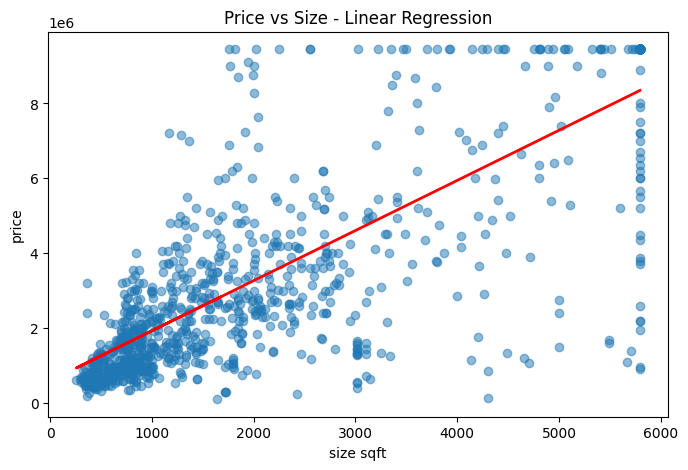

2. Multiple Linear Regression
R Score: 0.636
3. Classification Models
Logistic Regression: 0.742
KNN: 0.743
Naive Bayes: 0.608
Decision Tree: 0.714

Best model: KNN with accuracy: 0.743
 Predictions with Best Model
First 10 predictions:
        Actual    Predicted
0       Medium       Medium
1  low-economy  low-economy
2  low-economy  low-economy
3       Medium       Luxury
4       Medium       Medium
5       Medium       Medium
6       Medium       Medium
7  low-economy  low-economy
8       Medium       Medium
9       Medium       Medium

Final accuracy: 0.743


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import StandardScaler

# Load data
df = pd.read_csv('uae_real_estate_cleaned.csv')

print("data shape:", df.shape)
print("Columns:", df.columns.tolist())

#  Simple Linear Regression

print("1- Simple Linear Regression  Price vs Size")

X = df[['size_sqft']]
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model1 = LinearRegression()
model1.fit(X_train, y_train)

y_pred = model1.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = model1.score(X_test, y_test)

print(f"R Score: {r2:.3f}")


# Simple plot
plt.figure(figsize=(8, 5))
plt.scatter(X_test, y_test, alpha=0.5)
plt.plot(X_test, y_pred, color='red', linewidth=2)
plt.xlabel('size sqft')
plt.ylabel('price')
plt.title('Price vs Size - Linear Regression')
plt.show()

#  Multiple Regression

print("2. Multiple Linear Regression")

features = ['bedrooms', 'bathrooms', 'size_sqft', 'days_on_market']
X_multi = df[features]
y_multi = df['price']

X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_multi, y_multi, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_m)
X_test_scaled = scaler.transform(X_test_m)

model2 = LinearRegression()
model2.fit(X_train_scaled, y_train_m)

y_pred_multi = model2.predict(X_test_scaled)

mse_multi = mean_squared_error(y_test_m, y_pred_multi)
rmse_multi = np.sqrt(mse_multi)
r2_multi = model2.score(X_test_scaled, y_test_m)


print(f"R Score: {r2_multi:.3f}")


# classification

print("3- Classification Models")


X_class = df[['bedrooms', 'bathrooms', 'size_sqft']]
y_class = df['price_category']

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

# Scale for some models
scaler2 = StandardScaler()
X_train_c_scaled = scaler2.fit_transform(X_train_c)
X_test_c_scaled = scaler2.transform(X_test_c)

# Models 
models = {
    'Logistic Regression': LogisticRegression(),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier()
}

# Train and test each model
for name, model in models.items():
    if name in ['Logistic Regression', 'KNN']:
        model.fit(X_train_c_scaled, y_train_c)
        predictions = model.predict(X_test_c_scaled)
    else:
        model.fit(X_train_c, y_train_c)
        predictions = model.predict(X_test_c)
    
    accuracy = accuracy_score(y_test_c, predictions)
    print(f"{name}: {accuracy:.3f}")

# Find best model
best_model_name = None
best_accuracy = 0

for name, model in models.items():
    if name in ['Logistic Regression', 'KNN']:
        model.fit(X_train_c_scaled, y_train_c)
        predictions = model.predict(X_test_c_scaled)
    else:
        model.fit(X_train_c, y_train_c)
        predictions = model.predict(X_test_c)
    
    accuracy = accuracy_score(y_test_c, predictions)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model_name = name

print(f"\nbest model: {best_model_name} with accuracy: {best_accuracy:.3f}")

#  make predictions with best model

print(" predictions with Best Model")


best_model = models[best_model_name]

if best_model_name in ['Logistic Regression', 'KNN']:
    final_predictions = best_model.predict(X_test_c_scaled)
else:
    final_predictions = best_model.predict(X_test_c)

# Show  results
results = pd.DataFrame({
    'Actual': y_test_c.values,
    'Predicted': final_predictions
})

print("First 10 predictions:")
print(results.head(10))

print(f"\the accuracy: {accuracy_score(y_test_c, final_predictions):.3f}")



6- Cluster analysis

Using K=3 clusters

Cluster averages:
             price  size_sqft  bedrooms  bathrooms
cluster                                           
0        3784649.0     2446.0       3.0        4.0
1        8546686.0     5110.0       4.0        5.0
2        1428294.0      897.0       2.0        2.0

Properties in each cluster:
Cluster 0: 1548 properties (30.6%)
Cluster 1: 854 properties (16.9%)
Cluster 2: 2656 properties (52.5%)


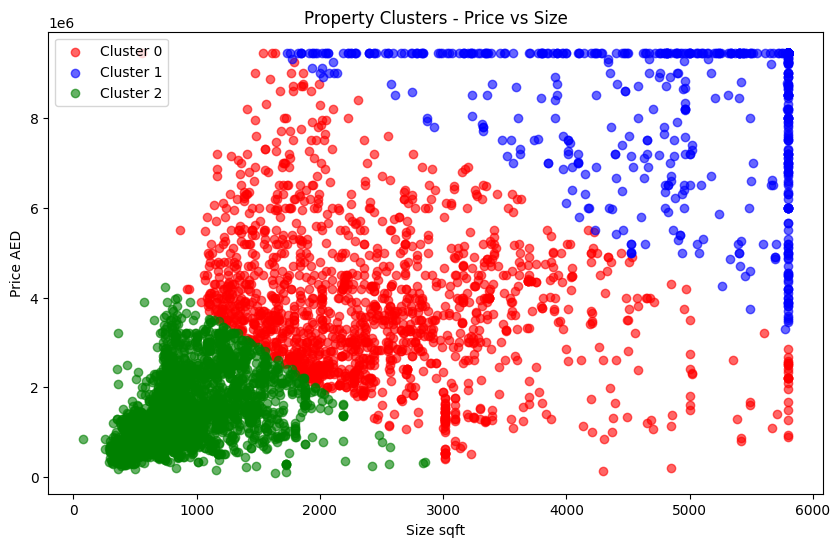


Cluster descriptions:
Cluster 0: Lower price, smaller size
Cluster 1: Medium price and size
Cluster 2: Higher price, larger size


In [19]:
# cluster
print("6- Cluster analysis")


#  price and size to cluster
X_cluster = df[['price', 'size_sqft']].copy()

# Remove miss
# X_cluster = X_cluster.dropna()

# Scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)


from sklearn.cluster import KMeans

# Test  clusters
for k in [2, 3, 4, 5]:
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(X_scaled)
    
    # Calculate sum of squares
    wcss = kmeans.inertia_
   

# Choose k=3 
print("\nUsing K=3 clusters")
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# Add clusters to original data
X_cluster['cluster'] = cluster_labels
df_clustered = df.copy()
df_clustered['cluster'] = cluster_labels

# See  each cluster 
print("\nCluster averages:")
cluster_means = df_clustered.groupby('cluster')[['price', 'size_sqft', 'bedrooms', 'bathrooms']].mean()
print(cluster_means.round(0))

# Count properties in each cluster
cluster_counts = df_clustered['cluster'].value_counts().sort_index()
print(f"\nProperties in each cluster:")
for i in range(3):
    count = cluster_counts[i]
    percentage = (count / len(df_clustered)) * 100
    print(f"Cluster {i}: {count} properties ({percentage:.1f}%)")

# Plot the clusters
plt.figure(figsize=(10, 6))
colors = ['red', 'blue', 'green']

for i in range(3):
    cluster_data = df_clustered[df_clustered['cluster'] == i]
    plt.scatter(cluster_data['size_sqft'], cluster_data['price'], 
               color=colors[i], alpha=0.6, label=f'Cluster {i}')

plt.xlabel('Size sqft')
plt.ylabel('Price AED')
plt.title('Property Clusters - Price vs Size')
plt.legend()
plt.show()

# cluster description
print("\nCluster descriptions:")
print("Cluster 0: Lower price, smaller size")
print("Cluster 1: Medium price and size") 
print("Cluster 2: Higher price, larger size")